<h1><strong><u>Naive Bayes Test (A4)</u></strong><h1>

In [1]:
import matplotlib.pyplot as plt            
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, PrecisionRecallDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbLearn_Pipeline

<h2><u>Data Loading and Preprocessing</u></h2>

In [2]:
pd.read_csv("./SMSSpamCollection.txt", sep="\t", header=None).to_csv("sms_spam_collection.csv", index=False, header=["target", "message"])

In [3]:
data = pd.read_csv("sms_spam_collection.csv")
data

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
X = data['message']
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(4457,)

(1115,)

(4457,)

(1115,)

In [5]:
#Display message counts
hams = data[(data['target'] == 'ham')]
spams = data[(data['target'] == 'spam')]
hams_count = hams.value_counts().sum()
spams_count = spams.value_counts().sum()
total_messages = hams_count + spams_count
spam_fraction = spams_count / total_messages

print("Number of ham messages: ", hams_count)
print("Number of spam messages: ", spams_count)
print("Fraction of spam messages: {:.2f}%".format(spam_fraction * 100))

Number of ham messages:  4825
Number of spam messages:  747
Fraction of spam messages: 13.41%


In [6]:
def custom_tokenizer(text):
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        import re
        en_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        new_text = text.lower() #lowercase

        new_text = re.sub(r"([^\w\s])", "", new_text) #remove punctuation

        for word in new_text.split(): #remove stopwords
            if word in en_stopwords:
                new_text = new_text.replace(word, "")
        
        new_text = word_tokenize(new_text) #tokenize

        new_text = [lemmatizer.lemmatize(token) for token in new_text] #lemmatize
        return new_text

<h2><strong><u>Bayesian Model Selection</u></strong><h2>

<h3><u>Validation Curves</u></h3>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ......................................clf__alpha=10; total time=   2.6s
[CV] END ..................................clf__alpha=0.0001; total time=   2.5s
[CV] END .....................................clf__alpha=0.1; total time=   2.5s
[CV] END ....................................clf__alpha=0.01; total time=   2.5s
[CV] END .......................................clf__alpha=1; total time=   2.5s
[CV] END ...................................clf__alpha=0.001; total time=   2.7s
[CV] END ..................................clf__alpha=0.0001; total time=   2.5s
[CV] END ...................................clf__alpha=0.001; total time=   2.5s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    7.7s remaining:    7.7s


[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.5s
[CV] END .......................................clf__alpha=1; total time=   0.5s
[CV] END ...................................clf__alpha=0.001; total time=   0.5s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.7s finished


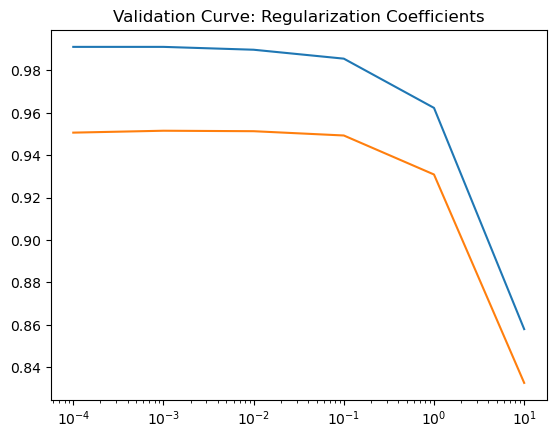

In [7]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=0)),
        ("clf", BernoulliNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

<h3><u>Findings From 'Regularization Coefficients' Validation Curve</u></h3>
The plot suggests that the regularization coefficients will not help the generalization of the model since the scores are parallel to each other. On the other hand, the scores are very good especially when regularization is at its lowest. Therefore, a BernoulliNB model with a very low regularization coefficient is the best model to run in the cross-validation test.

In [8]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=0)),
        ("clf", BernoulliNB())
    ]
) 
param_grid = {"clf__alpha": [0.009, 0.01, 0.03, 0.05, 0.1]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
nb_model = grid_search.best_estimator_
print(nb_model)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...................................clf__alpha=0.009; total time=   0.6s
[CV] END ...................................clf__alpha=0.009; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ...................................clf__alpha=0.009; total time=   0.6s
[CV] END ...................................clf__alpha=0.009; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ...................................clf__alpha=0.009; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END ....................................clf__alpha=0.03; total time=   0.7s
[CV] END ....................................clf_

<h3><u>Bayesian Training Learning Curves</u><h3>

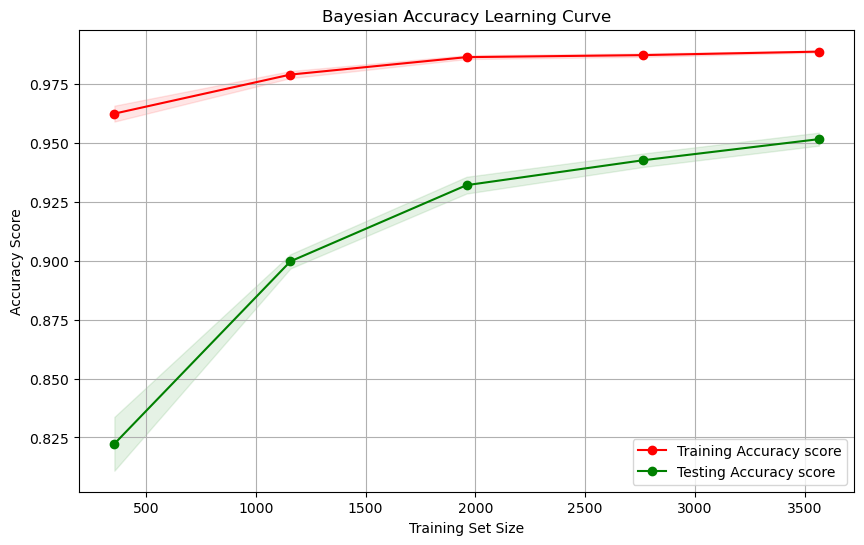

In [9]:
bayesian_train_sizes, bayesian_train_scores, bayesian_validation_scores = learning_curve(
    nb_model,
    X_train,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

# Calculate mean and standard deviation for scores
bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
bayesian_validation_scores_mean = np.mean(bayesian_validation_scores, axis=1)
bayesian_validation_scores_std = np.std(bayesian_validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title(f"Bayesian Accuracy Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel(f"Accuracy Score")
plt.grid()

plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                color="r")
plt.fill_between(bayesian_train_sizes, bayesian_validation_scores_mean - bayesian_validation_scores_std,
                bayesian_validation_scores_mean + bayesian_validation_scores_std, alpha=0.1,
                color="g")
plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
            label=f"Training Accuracy score")
plt.plot(bayesian_train_sizes, bayesian_validation_scores_mean, 'o-', color="g",
            label=f"Testing Accuracy score")

plt.legend(loc="best")
plt.show()

<h2><strong><u>Metrics</u></strong></h2>

<h3><u>Bayesian Training Results<u></h3>

In [10]:
#Cross-Validation Loop

nb_training_values = cross_val_score(nb_model, X_train, y_train, scoring='accuracy', cv=5)
print("Cross-validation Accuracy training scores: ", nb_training_values)
np_nb_training_values = np.array(nb_training_values)
average = np.mean(np_nb_training_values)
stDev = np.std(np_nb_training_values)
print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.95067265 0.94730942 0.95510662 0.95398429 0.95061728]
0.95  +/-  0.0028 



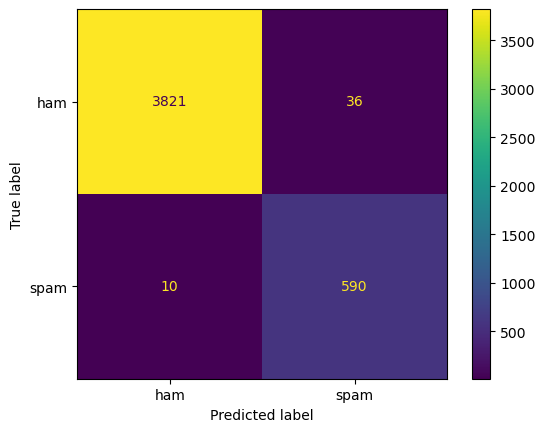

In [11]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(nb_model, X_train, y_train)

In [12]:
train_predictions = nb_model.predict(X_train)
nb_test_precision = precision_score(y_train, train_predictions, pos_label='spam')
print("Naive Bayes Test Precision: {:.2f}%".format(nb_test_precision * 100))

nb_test_recall = recall_score(y_train, train_predictions, pos_label='spam')
print("Naive Bayes Test Recall: {:.2f}%".format(nb_test_recall * 100))

nb_test_npv = precision_score(y_train, train_predictions, pos_label='ham')
print("Naive Bayes Negative Predictive Value Score: {:.2f}%".format(nb_test_recall * 100))

nb_test_specificity = recall_score(y_train, train_predictions, pos_label='ham')
print("Naive Bayes Specificity Score: {:.2f}%".format(nb_test_recall * 100))

Naive Bayes Test Precision: 94.25%
Naive Bayes Test Recall: 98.33%
Naive Bayes Negative Predictive Value Score: 98.33%
Naive Bayes Specificity Score: 98.33%


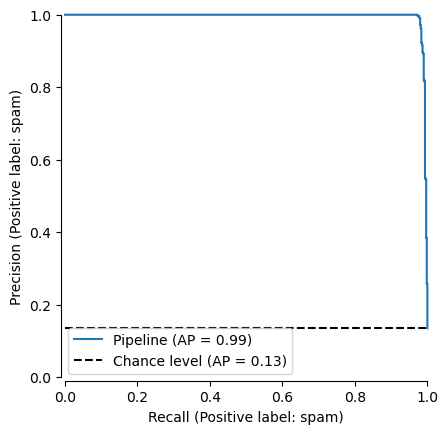

In [13]:
PrecisionRecallDisplay.from_estimator(nb_model, X_train, y_train, pos_label="spam", plot_chance_level=True, despine=True)

<h3><u>Bayesian Testing Results</u></h3>

In [14]:
test_predictions = nb_model.predict(X_test)

nb_test_accuracy = accuracy_score(y_test, test_predictions)
print("Naive Bayes Test Accuracy: {:.2f}%".format(nb_test_accuracy * 100))

nb_test_precision = precision_score(y_test, test_predictions, pos_label='spam')
print("Naive Bayes Test Precision: {:.2f}%".format(nb_test_precision * 100))

nb_test_recall = recall_score(y_test, test_predictions, pos_label='spam')
print("Naive Bayes Test Recall: {:.2f}%".format(nb_test_recall * 100))

nb_test_npv = precision_score(y_test, test_predictions, pos_label='ham')
print("Negative Predictive Value Score: {:.2f}%".format(nb_test_recall * 100))

nb_test_specificity = recall_score(y_test, test_predictions, pos_label='ham')
print("Specificity Score: {:.2f}%".format(nb_test_recall * 100))

Naive Bayes Test Accuracy: 96.68%
Naive Bayes Test Precision: 83.54%
Naive Bayes Test Recall: 93.20%
Negative Predictive Value Score: 93.20%
Specificity Score: 93.20%


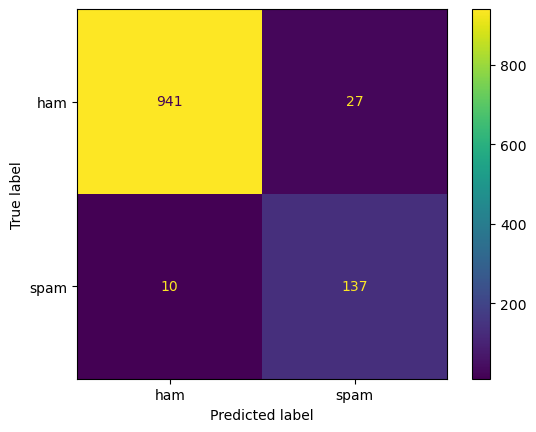

Exception ignored in: <function ResourceTracker.__del__ at 0x104331bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107331bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102af1bc0>
Traceback (most recent call last

In [15]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)